# RADI 6060 Homework 4 (Final)
#### Gweneth Andersen
#### 4/29/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# random number generator using the multiplicative congruential algorithm
class MultiplicativeCongruentialGenerator():
    def __init__(self, initialSeed: int = None, I1: int = 7**5, M: int = 2**31 - 1): 
        self.multiplier = I1
        self.modulus = M
        if initialSeed is None:
            initialSeed = int(self.modulus / 2)
        self.seed = initialSeed % self.modulus
        self.randomNumber = self.seed / self.modulus
        self.seeds = [self.seed]
        self.randomNumbers = [self.randomNumber]
    
    # generate and return the next random number in the multiplicative congruential sequence
    def generateNext(self):
        newSeed = (self.multiplier * self.seed) % self.modulus
        self.seed = newSeed
        self.seeds.append(self.seed)
        newRandomNumber = newSeed / self.modulus
        self.randomNumber = newRandomNumber
        self.randomNumbers.append(self.randomNumber)
        return newRandomNumber
    
    # generate N more random numbers and return them in a list
    def generateNextN(self, N: int):
        newRandomNumbers = []
        for i in range(N):
            newRandomNumber = self.generateNext()
            newRandomNumbers.append(newRandomNumber)
        return newRandomNumbers
    
class Medium():
    def __init__(self, xs: dict):
        self.xs = xs
        self.xs_a = self.xs["xs_a"]
        self.xs_s = self.xs["xs_s"]
        self.xs_total = {energy: self.xs_a[energy] + self.xs_s[energy] for energy in self.xs_a.keys()}
    
water_xs = {
    "xs_a": {
        15.0: 1.369,
        20.0: 5.439 * 10**-1,
        30.0: 1.458 * 10**-1
    },
    "xs_s": {
        15.0: 0,
        20.0: 0,
        30.0: 0
    }
}

water = Medium(water_xs)

class Simulator():
    def __init__(self, medium: Medium, rng: MultiplicativeCongruentialGenerator):
        self.medium = medium
        self.rng = rng
        self.bin_edges = []
        self.bin_widths = []
        self.bin_scores = {}
        
    def sampleSourceEnergy(self):
        R = self.rng.generateNext()
        if R <= 0.28:
            return 15.0
        elif R <= 0.78:
            return 20.0
        else:
            return 30.0
        
    def sampleCollisionDistance(self, E: float):
        R = self.rng.generateNext()
        collision_distance = -np.log(R) / self.medium.xs_total[E]
        return collision_distance
        
    def setBins(self, x: list):
        self.bin_edges = [(0, x[0])] + [(x[i], x[i+1]) for i in range(len(x) - 1)]
        self.bin_widths = [round(edges[1] - edges[0],3) for edges in self.bin_edges]
        self.bin_scores = {edges: {'count': 0, 'energy': {15.0: 0, 20.0: 0, 30.0: 0}} for edges in self.bin_edges}
    
    def simulate(self, N_histories: int, x: list):
        if len(self.bin_edges) == 0 or len(self.bin_widths) == 0 or len(self.bin_scores) == 0:
            self.setBins(x)
        for i in range(N_histories):
            source_energy = self.sampleSourceEnergy()
            collision_distance = self.sampleCollisionDistance(source_energy)
            for bin_ in self.bin_edges:
                if bin_[0] <= collision_distance < bin_[1]:
                    self.bin_scores[bin_]['energy'][source_energy] += source_energy
                    self.bin_scores[bin_]['count'] += 1
    
    def computeDeposition(self, N_histories: int, E: float):
        dep = []
        for score, dx in zip(self.bin_scores.values(), self.bin_widths):
            if score['count'] > 0 and dx != 0:
                dep.append(score['energy'][E]/(N_histories*dx))
            else:
                dep.append(0)
        return dep
    
    def computeUncertainties(self, N_histories: int, E: float=None, total: bool=False):
        if total and E is None:
            unc = []
            for score in self.bin_scores.values():
                bin_total = sum(score['energy'].values())
                E_counts = {E_: score['energy'][E_]/E_ for E_ in score['energy'].keys()} # counts for each energy in this bin
                bin_mean = bin_total / N_histories
                variance = (1 / (N_histories - 1)) * (
                    sum([
                        count * (E_ - bin_mean)**2 for E_, count in E_counts.items()
                    ])
                    + (N_histories - score['count']) * (bin_mean**2) # all histories with no event
                )
                unc.append(variance) # append the variance for this bin
            return unc
        elif E is not None:
            unc = []
            for score in self.bin_scores.values():
                E_bin_total = score['energy'][E]
                E_count = E_bin_total / E # count for this energy in this bin
                E_bin_mean = E_bin_total / N_histories
                variance = (1 / (N_histories - 1)) * (
                    E_count * (E - E_bin_mean)**2
                    + (N_histories - E_count) * (E_bin_mean**2) # all histories with no event or different energy event
                )
                unc.append(variance) # record variance for this bin
            return unc
        else:
            return [0]*len(self.bin_edges)
        
    def computeRelativeStandardDeviations(self, N_histories: int, E: float=None, total: bool=False):
        if total and E is None:
            unc = self.computeUncertainties(N_histories, total=True)
            std = []
            for i, score in enumerate(self.bin_scores.values()):
                bin_total = sum(score['energy'].values())
                bin_mean = bin_total / N_histories
                std_ = math.sqrt(unc[i] / N_histories) / bin_mean if bin_mean != 0 else 0 # normalize to bin mean
                std.append(std_)
            return std
        elif E is not None:
            unc = self.computeUncertainties(N_histories, E)
            std = []
            for i, score in enumerate(self.bin_scores.values()):
                E_bin_total = score['energy'][E]
                E_bin_mean = E_bin_total / N_histories
                std_ = math.sqrt(unc[i] / N_histories) / E_bin_mean if E_bin_mean != 0 else 0 # normalize to bin mean
                std.append(std_)
            return std
        else:
            return [0]*len(self.bin_edges)

Results for 1000 histories:
	15.0 keV min stdv: 0
	15.0 keV max stdv: 0.7067527852789118
	20.0 keV min stdv: 0
	20.0 keV max stdv: 0.33199598257140805
	30.0 keV min stdv: 0.13373784183483942
	30.0 keV max stdv: 1.0
	All energies min stdv: 0.13373784183483942
	All energies max stdv: 1.0
Results for 10000 histories:
	15.0 keV min stdv: 0
	15.0 keV max stdv: 1.0
	20.0 keV min stdv: 0.026410564508563324
	20.0 keV max stdv: 1.0
	30.0 keV min stdv: 0.042357039625308755
	30.0 keV max stdv: 0.2771836214480878
	All energies min stdv: 0.042357039625308755
	All energies max stdv: 0.2771836214480878
Results for 200000 histories:
	15.0 keV min stdv: 0
	15.0 keV max stdv: 0.316220650776479
	20.0 keV min stdv: 0.0059906818260470765
	20.0 keV max stdv: 0.10257372176301136
	30.0 keV min stdv: 0.009546992050164956
	30.0 keV max stdv: 0.058679579740607876
	All energies min stdv: 0.009546992050164956
	All energies max stdv: 0.058679579740607876
Results for 50000000 histories:
	15.0 keV min stdv: 0
	15.0 k

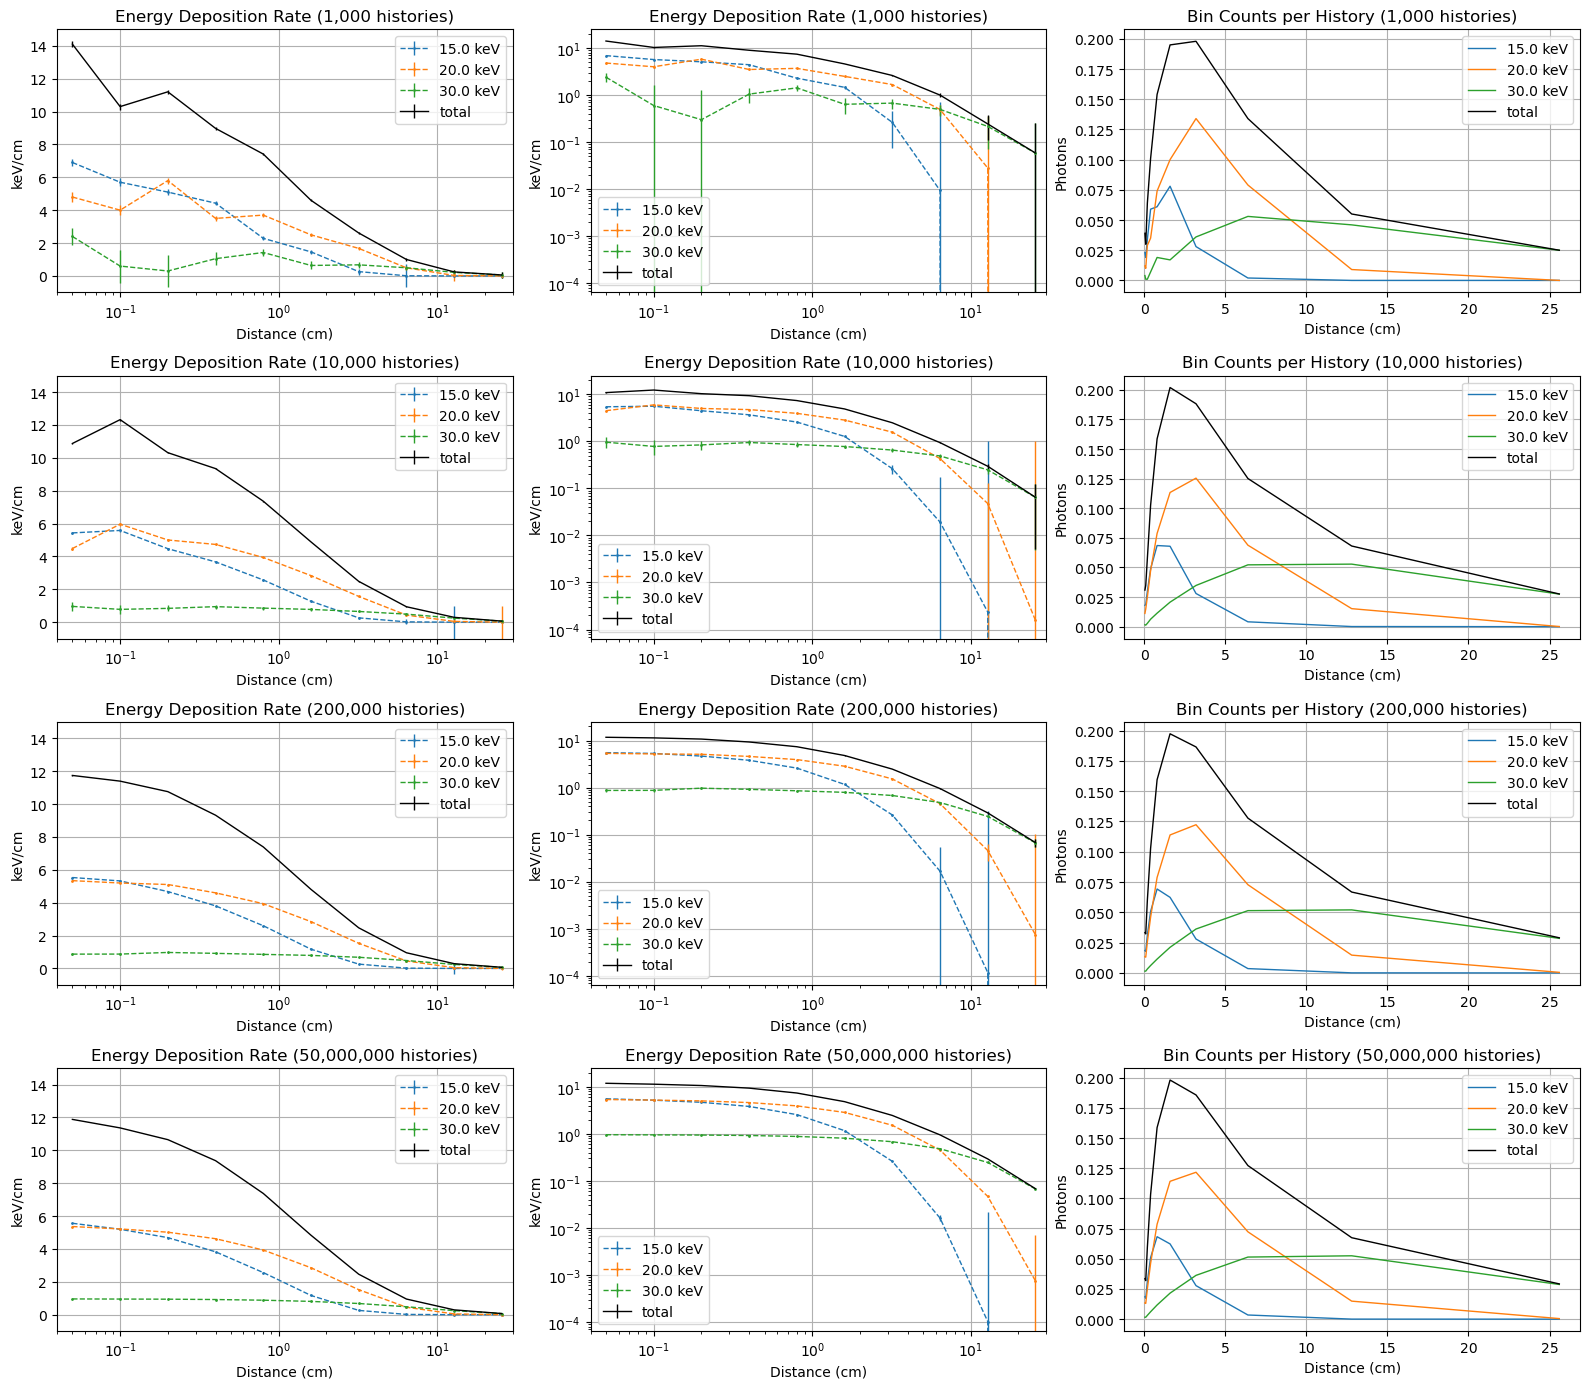

In [3]:
MCG = MultiplicativeCongruentialGenerator()
x = [0.05 * 2**i for i in range(10)]

import matplotlib.pyplot as plt
from matplotlib.scale import LogScale

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16,14))
axs = [a[0] for a in ax]
axslog = [a[1] for a in ax]
axsexp = [a[2] for a in ax]

for j, N in enumerate([1*10**3, 1*10**4, 2*10**5, 5*10**7]):
    print("Results for {} histories:".format(N))
    sim = Simulator(water, MCG)
    sim.simulate(N_histories=N, x=x)
    d_total = [0]*len(x)
    for E in [15.0, 20.0, 30.0]:
        d = sim.computeDeposition(N, E)
        std = sim.computeRelativeStandardDeviations(N, E)
        print("\t{} keV min stdv: {}".format(E, min(std)))
        print("\t{} keV max stdv: {}".format(E, max(std)))
        for i in range(len(d_total)):
            d_total[i] += d[i]
        axs[j].errorbar(x, d, yerr=std, linestyle='--', markersize=1, lw=1, marker='o', label="{} keV".format(E))
        axslog[j].errorbar(x, d, yerr=std, linestyle='--', markersize=1, lw=1, marker='o', label="{} keV".format(E))
        axsexp[j].plot(x, [score['energy'][E]/(E*N) for score in sim.bin_scores.values()], linestyle='-', lw=1, label="{} keV".format(E))

    std_total = sim.computeRelativeStandardDeviations(N, total=True)
    print("\tAll energies min stdv: {}".format(min(std)))
    print("\tAll energies max stdv: {}".format(max(std)))
    axs[j].errorbar(x, d_total, yerr=std_total, linestyle='-', markersize=1, lw=1, color="k", label="total")
    axslog[j].errorbar(x, d_total, yerr=std_total, linestyle='-', markersize=1, lw=1, color="k", label="total")
    axsexp[j].plot(x, [score['count']/N for score in sim.bin_scores.values()], linestyle='-', lw=1, color="k", label="total")

    axs[j].set_xscale(LogScale("x", base=10))
    axslog[j].set_xscale(LogScale("x", base=10))
    axs[j].set_xlim(5**-2, 30)
    axslog[j].set_xlim(5**-2, 30)
    axs[j].set_ylim(-1, 15)
    axslog[j].set_yscale(LogScale("y", base=10))
    axslog[j].set_ylim(5**-6, 5**2)
    axs[j].set_xlabel("Distance (cm)")
    axslog[j].set_xlabel("Distance (cm)")
    axsexp[j].set_xlabel("Distance (cm)")
    axs[j].set_ylabel("keV/cm")
    axslog[j].set_ylabel("keV/cm")
    axsexp[j].set_ylabel("Photons")
    axs[j].set_title("Energy Deposition Rate ({:,} histories)".format(N))
    axslog[j].set_title("Energy Deposition Rate ({:,} histories)".format(N))
    axsexp[j].set_title("Bin Counts per History ({:,} histories)".format(N))
    axs[j].legend(loc='upper right')
    axslog[j].legend(loc='lower left')
    axsexp[j].legend(loc='upper right')
    axs[j].grid()
    axslog[j].grid()
    axsexp[j].grid()
    
fig.tight_layout()
plt.savefig("hw4_plots.png")
plt.show()